# Udacity Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project, I have built deep learning pipeline to classify the traffic signs from the [German Traffic Signs dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The starting model is a convolutional neural network based on the [LeNe](http://yann.lecun.com/exdb/lenet/) architecture by Yann LeCun.

The project is organised by the following sections:
-  Data Summary and Exploration
-  Data Preprocessing 
-  Design and Test Model Architecture
-  Model Improvement
-  Testing and Results

In [ ]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

---
## Step 0: Load The Data

In [ ]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
print(X_valid.shape, y_valid.shape)

In [ ]:
print(X_test.shape, y_test.shape)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline
import pandas as pd

# Number of training examples
n_train = X_train.shape[0]
# Number of validation examples
n_validation = X_valid.shape[0]
# Number of testing examples.
n_test = X_test.shape[0]
# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]
# How many unique classes/labels there are in the dataset.
n_classes = pd.Series(y_train).nunique()

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation )
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


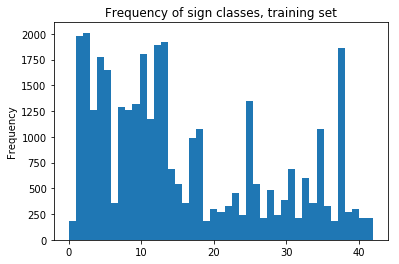

In [6]:
# visualize frequency of sign classes in the training set
pd.Series(y_train).plot.hist(title = "Frequency of sign classes, training set", bins = n_classes)


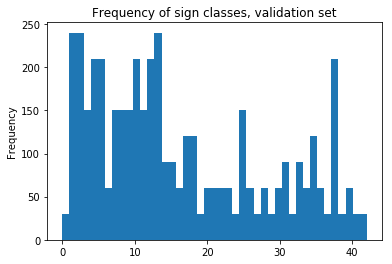

In [7]:
# visualize frequency of sign classes in the validation set
pd.Series(y_valid).plot.hist(title = "Frequency of sign classes, validation set", bins = n_classes)

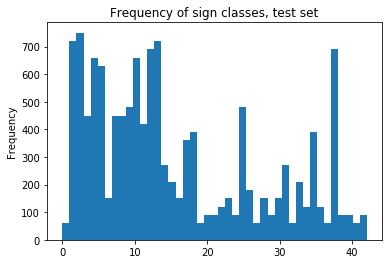

In [8]:
# visualize frequency of sign classes in the test set
pd.Series(y_test).plot.hist(title = "Frequency of sign classes, test set", bins = n_classes)

In [9]:
signs_df = pd.read_csv('signnames.csv')
signs_df['Occurence'] = [sum(y_train ==c) for c in range(n_classes)]

In [10]:
signs_df.set_index('ClassId', inplace = True)
signs_df.head()

,SignName,Occurence
ClassId,,
0,Speed limit (20km/h),180
1,Speed limit (30km/h),1980
2,Speed limit (50km/h),2010
3,Speed limit (60km/h),1260
4,Speed limit (70km/h),1770


In [11]:
# check class names of 5 most frequent classes
top_5 = signs_df.sort_values(['Occurence'], ascending = False).head()

In [12]:
ind = list(top_5.index)

### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

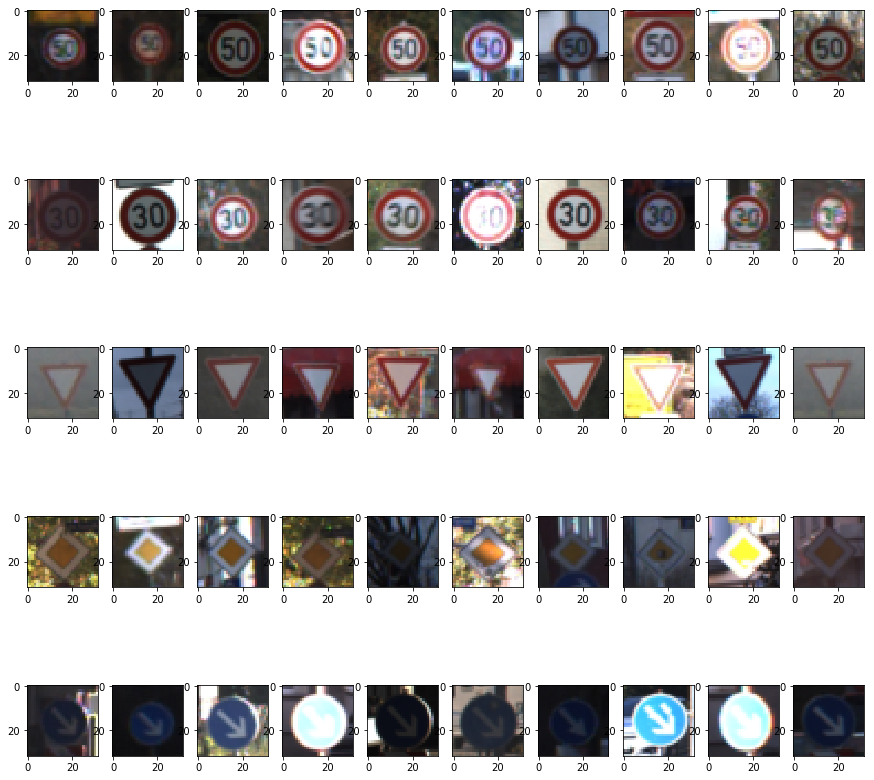

In [13]:
# Visualize 50 signs from the 5 most frequent classes

grid_spec = gridspec.GridSpec(5,10)
fig = plt.figure(figsize = (15,15))

for i in range(5):
    for j in range(10):
        plt.subplot(grid_spec[i,j])
        plt.imshow(random.choice(X_train[y_train == ind[i]]))


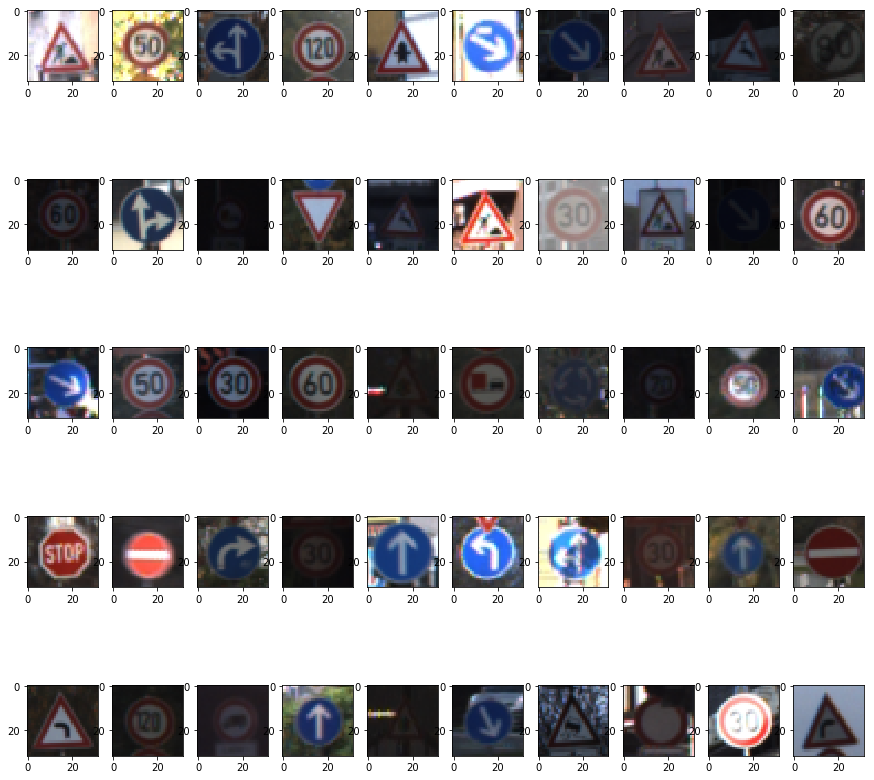

In [14]:
# visualize 50 random signs from the training set

grid_spec = gridspec.GridSpec(5,10)
fig = plt.figure(figsize = (15,15))

for i in range(5):
    for j in range(10):
        plt.subplot(grid_spec[i,j])
        plt.imshow(random.choice(X_train))

----

## Step 2: Design and Test of Model Architecture

In this section deep learning model is designed and implemented to recognize traffic signs [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The various aspects considered in this project:

- Neural network architecture
- Preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generation of artificial data.

An example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (normalization, grayscale, etc.)

The image data should be normalized so that the data has mean zero and equal variance. For image data, `pixel/255. - 0.5` is a quick way to approximately normalize the data, other methods can also be used.
The images differ significantly in terms of contrast and brightness, we will apply histogram equalization to improve feature extraction.

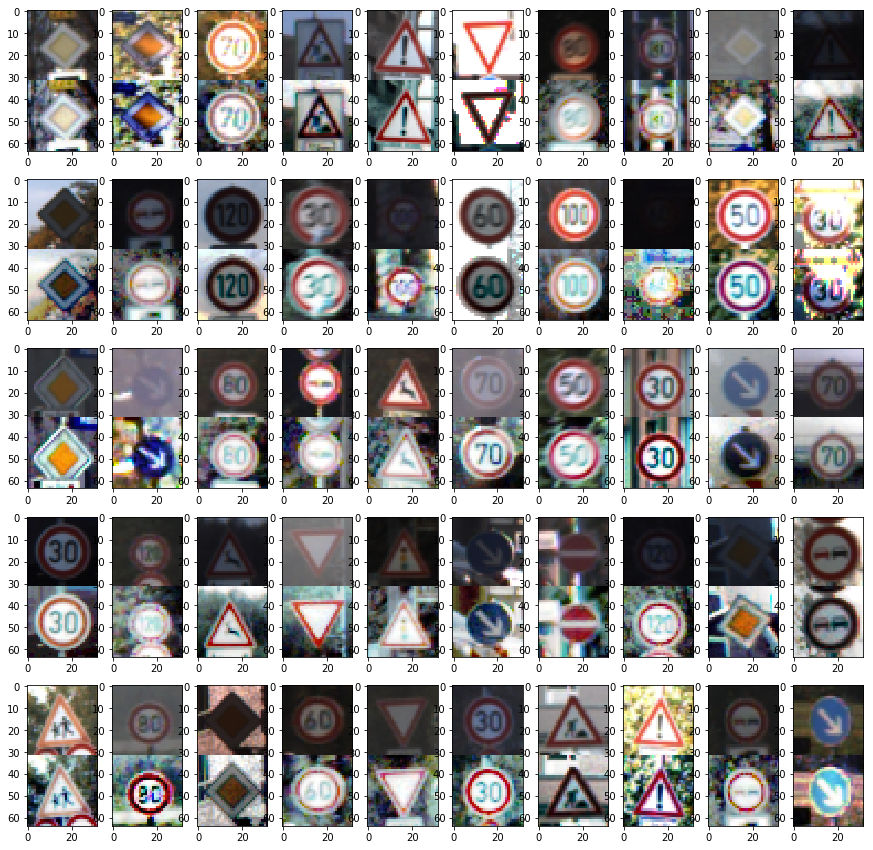

In [15]:
# Histogram equalization via https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
# Here we compare images before and after application of histogram equalization
grid_spec = gridspec.GridSpec(5,10)
fig = plt.figure(figsize = (15,15))

for i in range(5):
    for j in range(10):
        image = random.choice(X_train)
        equ = np.empty_like(image)
        equ[:,:,0] = cv2.equalizeHist(image[:,:,0])
        equ[:,:,1] = cv2.equalizeHist(image[:,:,1])
        equ[:,:,2] = cv2.equalizeHist(image[:,:,2])
        plt.subplot(grid_spec[i,j])
        plt.imshow(np.vstack((image,equ)))
       

In [16]:
def preprocess_image(image):
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    return image

In [17]:
X_train_orig = np.copy(X_train)
X_valid_orig = np.copy(X_valid)
X_test_orig = np.copy(X_test)

In [18]:
for i in range(n_train):
    X_train[i] = preprocess_image(X_train[i])

In [19]:
for i in range(n_validation):
    X_valid[i] = preprocess_image(X_valid[i])

In [20]:
for i in range(n_test):
    X_test[i] = preprocess_image(X_test[i])

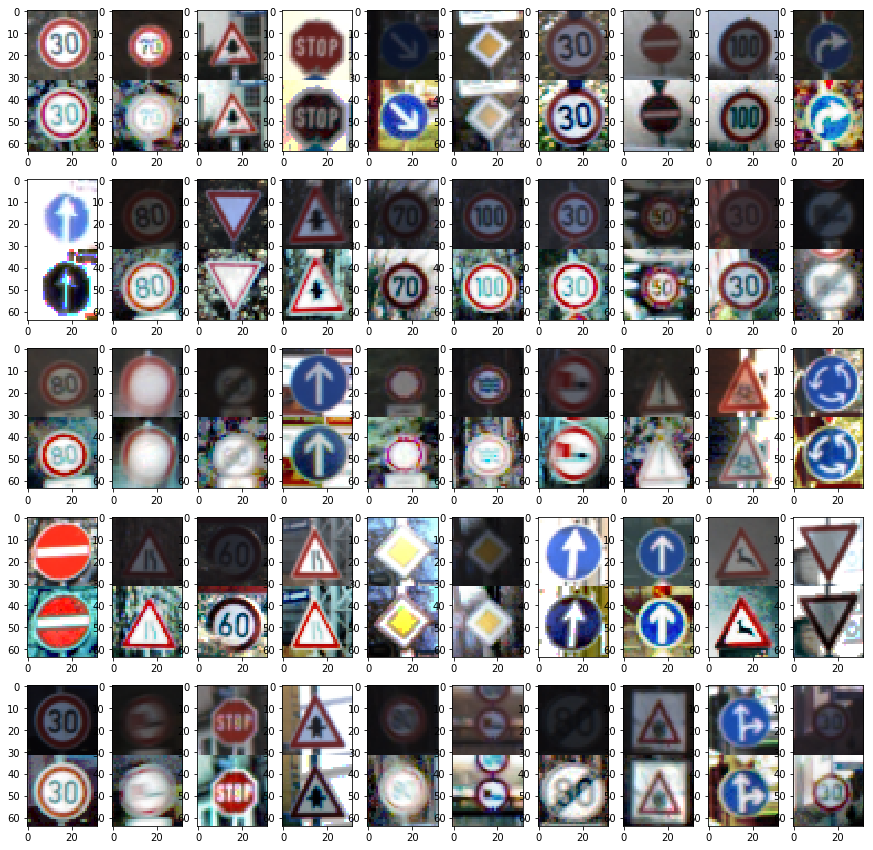

In [21]:
# plot results of Histogram equalization for the training set and compare to original images
grid_spec = gridspec.GridSpec(5,10)
fig = plt.figure(figsize = (15,15))
for i in range(5):
    for j in range(10):
        random_index  = random.choice(range(len(X_train)))
        img = np.vstack((X_train_orig[random_index],X_train[random_index]))
        plt.subplot(grid_spec[i,j])
        plt.imshow(img)

In [22]:
### Normalize data 
X_train =  X_train / 255. - 0.5
X_valid = X_valid / 255. - 0.5
X_test = X_test / 255. - 0.5
y_train_prep = y_train

### Setup TensorFlow

In [23]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train_prep)

In [24]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128
ALPHA = 0.001
KEEP_PROB = 0.5

### Model Architecture

In [25]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    #mu = 0
    #sigma = 0.01
    
    with tf.name_scope('conv_1'):
        # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
        conv1_W = tf.get_variable('conv1_W', shape=[5, 5, 3, 32], initializer = tf.contrib.layers.xavier_initializer())        
        conv1_b = tf.Variable(tf.zeros(32))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        # Pooling. Input = 28x28x32. Output = 14x14x32.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    with tf.name_scope('conv_2'):
        # Layer 2: Convolutional. Output = 10x10x16.
        conv2_W = tf.get_variable('conv2_W', shape=[5, 5, 32, 64], initializer = tf.contrib.layers.xavier_initializer())
        conv2_b = tf.Variable(tf.zeros(64))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        # Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    with tf.name_scope('fc_1'):    
        # Flatten. Input = 5x5x16. Output = 400.
        fc0   = flatten(conv2)
        # Layer 3: Fully Connected. Input = 400. Output = 120.
        fc1_W = tf.get_variable('fc_1', shape=(fc0.get_shape().as_list()[-1], 1024), initializer = tf.contrib.layers.xavier_initializer())        
        fc1_b = tf.Variable(tf.zeros(1024))
        fc1 = tf.matmul(fc0, fc1_W) + fc1_b
        fc1 = tf.nn.relu(fc1)
        #fc1 = tf.nn.dropout(fc1, keep_prob) #dropout applied only on fully connected layers as conv layers already regularize via shared weights 
        fc1 = tf.cond(is_training, lambda: tf.nn.dropout(fc1, keep_prob = KEEP_PROB), lambda: fc1)
 
    with tf.name_scope('fc_2'):
        # Layer 4: Fully Connected. Input = 1024. Output = 84.
        fc2_W = tf.get_variable('fc_2', shape=(fc1.get_shape().as_list()[-1], 1024), initializer = tf.contrib.layers.xavier_initializer())        
        fc2_b  = tf.Variable(tf.zeros(1024))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)
        fc2 = tf.nn.relu(fc2)
        #fc2 = tf.nn.dropout(fc2, keep_prob) #dropout applied only on fully connected layers as conv layers already regularize via shared weights 
        fc2 = tf.cond(is_training, lambda: tf.nn.dropout(fc2, keep_prob = KEEP_PROB), lambda: fc2)

    with tf.name_scope('logit'):    
        # Layer 5: Fully Connected. Input = 84. Output = 10.
        #logit_W  = tf.Variable(tf.truncated_normal(shape=(fc2.get_shape().as_list()[-1], n_classes), mean = mu, stddev = sigma))
        logit_W = tf.get_variable('logit_W', shape=(fc2.get_shape().as_list()[-1], n_classes), initializer = tf.contrib.layers.xavier_initializer())        
        logit_b  = tf.Variable(tf.zeros(n_classes))
        logits = tf.matmul(fc2, logit_W) + logit_b
        weights = [fc1_W, fc2_W, logit_W] # only fully connected layers' weight regularized - conv layers regularized via shared weights
    
    return logits, weights

In [26]:
# regularization function
def regularization_cost(weights, alpha = ALPHA):
    reg_cost = 0.0
    for weight in weights:
        reg_cost += alpha * tf.nn.l2_loss(weight)
    return reg_cost    

## Features and labels

In [27]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
tf.add_to_collection('x',x)

y = tf.placeholder(tf.int32, (None))
tf.add_to_collection('y',y)

keep_prob = tf.placeholder(tf.float32)
tf.add_to_collection('keep_prob',keep_prob)

one_hot_y = tf.one_hot(y, n_classes)
tf.add_to_collection('one_hot_y',one_hot_y)

is_training = tf.placeholder(tf.bool)
tf.add_to_collection('is_training', is_training)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [28]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
learning_rate = 0.001

logits, weights = LeNet(x)
tf.add_to_collection('logits',logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_op = tf.reduce_mean(cross_entropy) + regularization_cost(weights, ALPHA)
tf.add_to_collection('loss_op',loss_op)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

### Model evaluation

In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.add_to_collection('accuracy_op',accuracy_op)
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, is_training: False})
        total_loss += (loss * len(batch_x))
        total_accuracy += (accuracy * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

In [52]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    training_accuracies = []
    training_losses = []
    
    validation_accuracies = []
    validation_losses = []
    
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, _ = sess.run([train_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, is_training: True, keep_prob : KEEP_PROB})
        # training loss and accuracy after an epoch
        loss_tr, acc_tr = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, is_training: False})
        training_losses.append(loss_tr)
        training_accuracies.append(acc_tr)
        # validation loss and acuracy after an epoch
        
        validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("train loss: {:.3f} validation Loss = {:.3f} train accuracy {:.3f} validation accuracy = {:.3f}"\
              .format(loss_tr, validation_loss, acc_tr, validation_accuracy))
        print()
    
    # compute test loss    
    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("test loss: {:.3f}, test accuracy {:.3f}".format(test_loss, test_accuracy))    
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
train loss: 0.604 validation Loss = 0.677 train accuracy 0.928 validation accuracy = 0.924

EPOCH 2 ...
train loss: 0.385 validation Loss = 0.470 train accuracy 0.991 validation accuracy = 0.965

EPOCH 3 ...
train loss: 0.309 validation Loss = 0.395 train accuracy 0.991 validation accuracy = 0.966

EPOCH 4 ...
train loss: 0.228 validation Loss = 0.351 train accuracy 1.000 validation accuracy = 0.971

EPOCH 5 ...
train loss: 0.213 validation Loss = 0.285 train accuracy 1.000 validation accuracy = 0.976

EPOCH 6 ...
train loss: 0.197 validation Loss = 0.280 train accuracy 1.000 validation accuracy = 0.971

EPOCH 7 ...
train loss: 0.190 validation Loss = 0.281 train accuracy 1.000 validation accuracy = 0.968

EPOCH 8 ...
train loss: 0.181 validation Loss = 0.274 train accuracy 1.000 validation accuracy = 0.963

EPOCH 9 ...
train loss: 0.184 validation Loss = 0.235 train accuracy 1.000 validation accuracy = 0.984

EPOCH 10 ...
train loss: 0.184 validation Loss = 0.

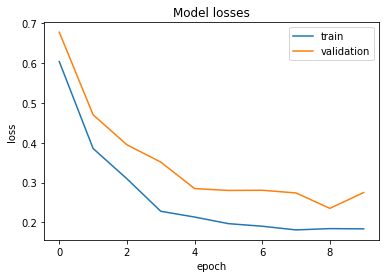

In [53]:
# plot losses
plt.plot(training_losses)
plt.plot(validation_losses)
plt.title('Model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

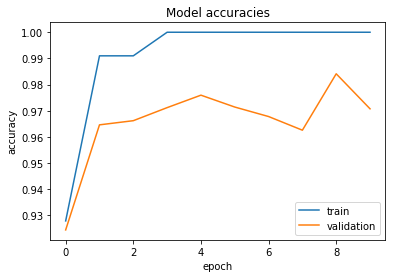

In [54]:
# plot accuracy
plt.plot(training_accuracies)
plt.plot(validation_accuracies)
plt.title('Model accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

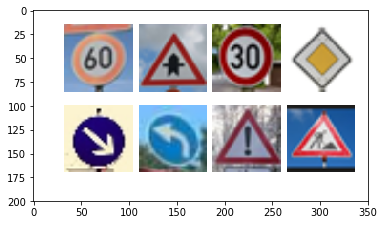

In [101]:
image = Image.open('data/test_images/german_signs.png')
image = np.asarray(image)
plt.imshow(image)

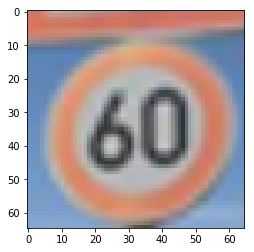

In [102]:
image1 = image[15:80,35:100]
plt.imshow(image1)

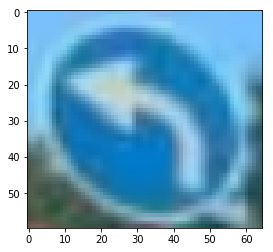

In [103]:
image2 = image[105:165,115:180]
plt.imshow(image2)

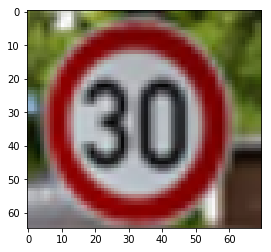

In [104]:
image3 = image[15:80,190:260]
plt.imshow(image3)

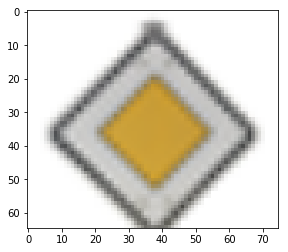

In [105]:
image4 = image[15:80,265:340]
plt.imshow(image4)

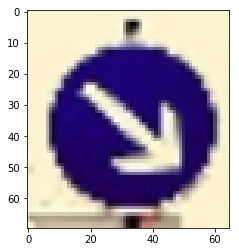

In [106]:
image5 = image[100:170,35:100]
plt.imshow(image5)

In [107]:
img1 = cv2.cvtColor(image1, cv2.COLOR_BGRA2BGR)
img1 = cv2.resize(img1,(32,32))
img1.shape

(32, 32, 3)

In [108]:
img2 = cv2.cvtColor(image2, cv2.COLOR_BGRA2BGR)
img2 = cv2.resize(img2,(32,32))
img2.shape

(32, 32, 3)

In [109]:
img3 = cv2.cvtColor(image3, cv2.COLOR_BGRA2BGR)
img3 = cv2.resize(img3,(32,32))
img3.shape

(32, 32, 3)

In [110]:
img4 = cv2.cvtColor(image4, cv2.COLOR_BGRA2BGR)
img4 = cv2.resize(img4,(32,32))
img4.shape

(32, 32, 3)

In [111]:
img5 = cv2.cvtColor(image5, cv2.COLOR_BGRA2BGR)
img5 = cv2.resize(img5,(32,32))
img5.shape

(32, 32, 3)

In [117]:
test_labels = [3, 34, 1, 12, 38]

In [113]:
test_images = [img1,img2,img3,img4,img5]

In [114]:
for i in range(5):
    test_images[i] = test_images[i] /255. - 0.5 

### Predict the Sign Type for Each Image

### Predict the Sign Type for Each Image and Analyze Performance

In [74]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    new_test_loss, new_test_accuracy = evaluate(X_test, y_test)
    print("test loss: {:.3f}, test accuracy {:.3f}".format(new_test_loss, new_test_accuracy))    
    

test loss: 0.321, test accuracy 0.957


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [115]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: test_images, is_training: False})
    top_k_result = sess.run(top_k, feed_dict={x: test_images, is_training: False})

In [121]:
top_k_result.values
# the result in line with analyze performance section above

array([[  8.50756168e-01,   5.63613623e-02,   1.49807213e-02,
          8.88214260e-03,   7.73689477e-03],
       [  9.98303056e-01,   1.07583508e-03,   8.94660552e-05,
          8.64213798e-05,   6.42974992e-05],
       [  7.65996158e-01,   5.79268448e-02,   5.13534360e-02,
          2.57926751e-02,   1.66379698e-02],
       [  9.99977350e-01,   5.98692850e-06,   5.45080184e-06,
          2.95495329e-06,   2.55283726e-06],
       [  1.00000000e+00,   3.59347663e-10,   8.63994726e-12,
          6.84894589e-12,   1.71667238e-12]], dtype=float32)

In [122]:
top_k_result.indices

array([[ 3, 25, 13,  6,  2],
       [34, 38, 41, 36, 30],
       [ 1,  6, 13,  2, 31],
       [12, 14, 26, 35, 13],
       [38, 36, 34,  2, 20]], dtype=int32)